# Chapter 1: Greenhouses Gases - The Prime Suspects

### Crafting Plots Based on [the Relevant Climate Indicators' Report](https://climate.copernicus.eu/climate-indicators/greenhouse-gas-concentrations).

The escalating narrative of climate change and the increasing mercury in Earth's thermometer have been heating up conversations around the globe in recent years. No longer limited to just scientific circles, it's a discussion that's impacting nearly every facet of our lives. At the heart of this climate crisis is a group of compounds known as Greenhouse Gases (GHGs). So, let's dive into this tutorial and explore the changes in concentrations of two key GHGs – carbon dioxide (CO$_2$) and methane (CH$_4$) – over the past few decades.

In this tutorial, we'll take you through how to:

1. Search, download and view data that's freely available in the [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/home) and [Atmosphere Data Store](https://ads.atmosphere.copernicus.eu/cdsapp#!/home).
2. Calculate global and regional monthly timeseries.
3. Mask the data and use spatiotemporal subsets for plotting.
4. View timeseries and delve into trend analysis.
5. Create gridded plots and dessect spatial variations.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <!-- <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=reanalysis-climatology.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th> -->
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/01_greenhouse_gases/01_greenhouse_gases.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/01_greenhouse_gases/01_greenhouse_gases.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

### Section 1. Install & Import the Necessary Packages

Our first order of business is to download and import the necessary libraries for this tutorial. You can find the complete environment, replete with all the libraries needed for this and other tutorials, in the GitHub repository. If you're running these tutorials on your local computer, you can install the environment in Linux with the simple command: `conda env create -f environment.yml`. This is your best bet for a seamless experience. If you're using this tutorial in Google Colab, most of the required libraries are already pre-installed, with only a few needing to be downloaded.

<div class="alert alert-block alert-warning">
    
<b>NOTE</b>: <br>
After executing the cell below, you might receive a prompt from Google Colab to "Restart the Runtime". If this occurs, kindly restart the runtime and proceed to the next cell.
</div>

In [1]:
# download libraries not available in the default Google Colab environment
%pip install cdsapi

# need some extra arguments for intalling cartopy otherwise some features of this library break the script if it is run in Google Colab 
%pip install shapely cartopy --no-binary shapely --no-binary cartopy --force # more info at https://github.com/SciTools/cartopy/issues/1490

Now, let's introduce all the necessary libraries to our environment. We've grouped the libraries based on their functionality: general libraries, libraries for data analysis, and plotting libraries.

In [1]:
# General libraries
from string import ascii_lowercase as ABC # String operations
import datetime # date
import calendar # date calculations
import zipfile # for unzipping data
import os # operating system interfaces library
import cdsapi # CDS API
import urllib3 # Disable warnings for data download via API
urllib3.disable_warnings()

# Libraries for working with multidimensional arrays
import numpy as np # for n-d arrays
import pandas as pd # for 2-d arrays (including metadata for the rows & columns)
import xarray as xr # for n-d arrays (including metadata for all the dimensions)

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.geoaxes

The following code is used to maintain consistent plotting across all tutorials. However, it **will NOT work in Google Colab** or other cloud services, unless you include the file (available in the GitHub repository) in the cloud and in the same directory as this notebook, and use the correct path, e.g.
 `plt.style.use('copernicus.mplstyle')`.

In [2]:
plt.style.use('../copernicus.mplstyle') # use the predefined matplotlib style for consistent plotting across all tutorials

### Section 2. Retrieve Data from CDS

Let's kick off by creating a dedicated folder for all our data. Keeping things organised is always a great first step.

In [3]:
dir_loc = 'data/' # assign folder for storing the downloaded data
os.makedirs(dir_loc, exist_ok=True) # create the folder if not available

#### Input CDS API Key

Next, we'll tap into the Climate Data Store (CDS) using the powerful CDS API. To do this, we need to manually set the CDS API credentials. We have to define two variables: URL and KEY. Your KEY is a string that combines your personal User ID and CDS API key. To get these, just register or [log in to the CDS](http://cds.climate.copernicus.eu), then head over to https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed under "key:". Replace the `#########` below with the your copied string.

<div class="alert alert-block alert-success">
    <b>Good to know</b>: <br>
      If you're already a CDS user, you can locate your `KEY` in a file named `.cdsapirc` in your home directory. On Linux, for instance, you can pull out the `KEY` with a quick `cat ~/.cdsapirc`.
</div>

In [4]:
# CDS key
cds_url = 'https://cds.climate.copernicus.eu/api/v2'
cds_key = '########' # please add your key here the format should be as {uid}:{api-key}

#### Fetch GHG Data from Satellite Products Available at CDS

CDS is a wonderland of data, and users can explore all the available datasets using the search option. Once you've found your dataset, you can see the exact API request from the download tab. For example, through [this link](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-methane?tab=form), you can lay your hands on the satellite methane data. For this tutorial, we've selected the following options:

- Processing level: Level 3
- Variable: Column-averaged dry-air mixing ratios of methane (XCH4) and related variables
- Version: 4.4
- Format: zip

In [5]:
c = cdsapi.Client(url=cds_url, key=cds_key)

c.retrieve(
    'satellite-methane',
    {
        'format': 'zip',
        'processing_level': 'level_3',
        'sensor_and_algorithm': 'merged_obs4mips',
        'version': '4.4',
        'variable': 'xch4',
    },
    f'{dir_loc}satellites_CH4.zip')

c.retrieve(
    'satellite-carbon-dioxide',
    {
        'format': 'zip',
        'processing_level': 'level_3',
        'sensor_and_algorithm': 'merged_obs4mips',
        'version': '4.4',
        'variable': 'xco2',
    },
    f'{dir_loc}satellites_CO2.zip')

2023-07-02 11:10:37,199 INFO Welcome to the CDS
2023-07-02 11:10:37,200 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-methane
2023-07-02 11:10:37,594 INFO Request is queued
2023-07-02 11:10:38,695 INFO Request is running
2023-07-02 11:10:42,644 INFO Request is completed
2023-07-02 11:10:42,645 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data8/dataset-satellite-methane-bab42cde-1850-4bee-873b-df100bb32aa4.zip to data/satellites_CH4.zip (15.1M)
2023-07-02 11:10:53,223 INFO Download rate 1.4M/s   
2023-07-02 11:10:53,419 INFO Welcome to the CDS
2023-07-02 11:10:53,419 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-carbon-dioxide
2023-07-02 11:10:53,712 INFO Request is queued
2023-07-02 11:10:54,812 INFO Request is running
2023-07-02 11:10:58,759 INFO Request is completed
2023-07-02 11:10:58,760 INFO Downloading https://download-0017.copernicus-climate.eu/cache-compute-001

Result(content_length=12831918,content_type=application/zip,location=https://download-0017.copernicus-climate.eu/cache-compute-0017/cache/data7/dataset-satellite-carbon-dioxide-0f6e5835-8242-4ce8-b7b0-3aa132e04ee6.zip)

The data is downloaded in a compressed zip format. We'll unzip these and give them more intuitive names for easier access.

In [6]:
# unzip the satellite data, rename the file and delete the original zip
for i_ghg in ['CO2', 'CH4']: # loop through both variables
    with zipfile.ZipFile(f'{dir_loc}satellites_{i_ghg}.zip','r') as zip_ref:
        zip_ref.extractall(dir_loc) # unzip file
        source_file = '200301_202112-C3S-L3_GHG-GHG_PRODUCTS-MERGED-MERGED-OBS4MIPS-MERGED-v4.4.nc' # the name of the unzipped file
        os.rename(f'{dir_loc}{source_file}', f'{dir_loc}satellites_{i_ghg}.nc') # rename to more intuitive name
        os.remove(f'{dir_loc}satellites_{i_ghg}.zip') # delete original zip file

# read the data with xarray
co2_satellites = xr.open_dataset(f'{dir_loc}satellites_CO2.nc')
ch4_satellites = xr.open_dataset(f'{dir_loc}satellites_CH4.nc')

Let's dive into the satellite data. You'll notice that the grid is set to 5 degrees latitude and longitude, and the time coordinate corresponds to the median day of the relevant month. The dataset is rich with different variables, including CO$_2$ values and standard deviations that tell us about uncertainty.

In [7]:
co2_satellites

<xarray.Dataset>
Dimensions:                  (time: 228, bnds: 2, lat: 36, lon: 72, pressure: 10)
Coordinates:
  * time                     (time) datetime64[ns] 2003-01-16T12:00:00 ... 20...
  * lat                      (lat) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon                      (lon) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Dimensions without coordinates: bnds, pressure
Data variables:
    time_bnds                (time, bnds) datetime64[ns] ...
    lat_bnds                 (lat, bnds) float64 ...
    lon_bnds                 (lon, bnds) float64 ...
    pre                      (pressure) float64 ...
    pre_bnds                 (pressure, bnds) float64 ...
    land_fraction            (lat, lon) float64 ...
    xco2                     (time, lat, lon) float32 ...
    xco2_nobs                (time, lat, lon) float64 ...
    xco2_stderr              (time, lat, lon) float32 ...
    xco2_stddev              (time, lat, lon) float32 ...
    column_averaging_kernel  (time, pressure, lat, lon) float32 ...
    vmr_profile_co2_apriori  (time, pressure, lat, lon) float32 ...
Attributes: (12/28)
    activity_id:            obs4MIPs
    comment:                Since long time, climate modellers use ensemble a...
    contact:                Maximilian Reuter (maximilian.reuter@iup.physik.u...
    Conventions:            CF-1.7 ODS-2.1
    creation_date:          2022-07-10T09:25:22Z
    data_specs_version:     2.1.0
    ...                     ...
    source_version_number:  v4.4
    title:                  C3S XCO2 v4.4
    tracking_id:            ca42b88b-c774-4a16-9ad8-a49f9a4839fd
    variable_id:            xco2
    variant_info:           Best Estimate
    variant_label:          BE

<div class="alert alert-block alert-warning">
    
<b>NOTE</b>: <br>
The datasets we've chosen cover up until 2021. For those with a thirst for more recent data, you can find the latest satellite measurements [here](http://www.iup.uni-bremen.de/~ghguser/gosat_focal.php).  
</div>

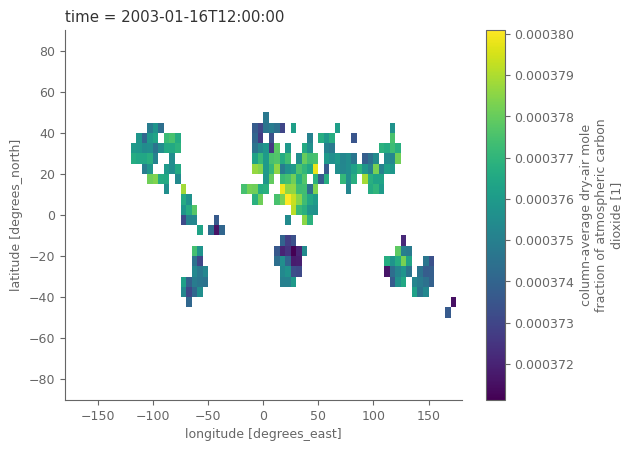

In [8]:
# "quick and dirty" plot of the data
co2_satellites['xco2'].isel(time=0).plot() 

Since we have a distinct `xr.Dataset` for each GHG, it's handier to combine them into one `xr.DataArray` with an additional `ghg` dimension.

In [9]:
# monthly sampled, spatially resolved GHG concentration in the atmosphere
concentration = xr.merge([co2_satellites['xco2'], ch4_satellites['xch4']]).to_array('ghg')

# associated standard errors
std_error = xr.merge([co2_satellites['xco2_stderr'], ch4_satellites['xch4_stderr']]).to_array('ghg')
std_error = std_error.assign_coords(ghg=['xco2', 'xch4']) # rename the standard errors for having same names as with the "concentration" array

# associated land fraction; is the same for CO2 and CH4
land_fraction = co2_satellites['land_fraction']
is_land = land_fraction >= 0.5  # anything with land_fraction of at least 50% is considered as land
is_land.name = 'is_land'

concentration.to_dataset('ghg') # for briefly checking the variable its better to see it as 'dataset' so that it's visually nicer

<xarray.Dataset>
Dimensions:  (time: 228, lat: 36, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-16T12:00:00 ... 2021-12-16T12:00:00
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
Data variables:
    xco2     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    xch4     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    standard_name:  dry_atmosphere_mole_fraction_of_carbon_dioxide
    long_name:      column-average dry-air mole fraction of atmospheric carbo...
    units:          1
    cell_methods:   time: mean
    fill_value:     1e+20
    comment:        Satellite retrieved column-average dry-air mole fraction ...

You'll notice after merging that the `attrs` of the `DataArray` aren't quite right. Let's quickly adjust them:

In [10]:
concentration = concentration.assign_attrs({
    'standard_name': 'dry_atmosphere_mole_fraction',
    'long_name': 'column-average dry-air mole fraction',
    'comment': 'Satellite retrieved column-average dry-air mole fraction'
})

In [11]:
# change temporal coordinates to refer to the start of the month
concentration = concentration.assign_coords( {'time': pd.to_datetime(concentration.time.dt.strftime('%Y%m01'))} ) # date at start of month
std_error = std_error.assign_coords( {'time': pd.to_datetime(std_error.time.dt.strftime('%Y%m01'))} )

concentration.time

<xarray.DataArray 'time' (time: 228)>
array(['2003-01-01T00:00:00.000000000', '2003-02-01T00:00:00.000000000',
       '2003-03-01T00:00:00.000000000', ..., '2021-10-01T00:00:00.000000000',
       '2021-11-01T00:00:00.000000000', '2021-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2021-12-01

### Section 3. Calculate the GHG Concentrations and Growth Rates

In this section, we'll dig into the data to calculate monthly averages of both global and regional GHG concentrations. We'll also be computing a 12-month temporally-smoothed global average to erase possible seasonal effects. We've broken down the process into several steps for clarity.

An important note on values over the ocean: water doesn't reflect short-wave infrared spectral region very well, so it requires a specific observation mode. However, not all the satellites used for this dataset have this mode, which is why we'll consider **values over land only** in this analysis.

In [12]:
concentration = concentration.where(is_land)
std_error = std_error.where(is_land)

#### Define regions of interest

In this tutorial, we'll centre our attention on three specific regions: (i) globally, excluding the poles which are nearly data deficient, (ii) the Northern Hemisphere, and (iii) the Southern Hemisphere.

In [13]:
region_of_interest = {
    'Global': {'lat': slice(-60, 60), 'lon': slice(-180, 180)},
    'Northern Hemishpere': {'lat': slice(0, 60), 'lon': slice(-180, 180)},
    'Southern Hemisphere': {'lat': slice(-60, 0), 'lon': slice(-180, 180)}
}

#### Temporal smoothing

Let's now gather the auxiliary data needed for temporal smoothing. We'll need to be extra meticulous here, as we must remember that each month has a different number of days.

In [14]:
smoothed_n_months = 12 # months used for the temporal smoothing

# get number of days for each month
years = concentration.time.dt.year.values
months = concentration.time.dt.month.values
days_month = [calendar.monthrange(yr, mn)[1] for yr, mn in zip(years, months)]

# temporal weights as xarray object (helps with automated alignment of the data for the calculations at the next steps)
weights_temporal = concentration.time.astype(int)*0+days_month 

# weights should be changed to NaN for the cells that hava NaN in the relevant month
weights_temporal = weights_temporal.where(concentration.notnull())

Now, it's time to compute the temporally smoothed data for each grid cell.

In [15]:
# rolling sum of the product of satellite measurements with the days per month
temp_smoothed = (concentration*weights_temporal).rolling(time=smoothed_n_months, min_periods=1, center=True).sum()
# min_periods=1 is needed, so that even if there is only 1 non-NaN value, there will be a result and not NaN

# divide with total number of days for getting the final weighted temporally-smoothed timeseries
temp_smoothed = temp_smoothed/weights_temporal.rolling(time=smoothed_n_months, min_periods=1, center=True).sum()

#### Spatial average

Now, let's dive into the spatial averaging process.

Our data follows a lat/lon projection system, but here's an interesting fact: this system doesn't allocate equal areas to all grid cells. In reality, as we venture closer to the poles, the cell areas shrink. However, this can be counteracted by adjusting the cells with the cosine of their latitude. Take a look at the forthcoming plot and you'll spot that grid cells nearer to the poles bear less weight than those cosying up to the tropics.

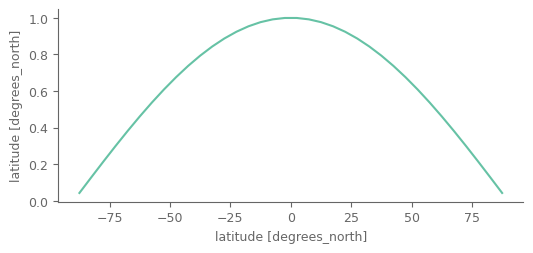

In [16]:
weights_spatial = np.cos(np.deg2rad(concentration.lat)).clip(0, 1) # weights for CO2 satellite data
# the clip function above is for reassuring that all values will be between 0-1 regardless of the  of machine's precision
weights_spatial.plot(figsize=(6, 2.5))

For a cleaner presentation and better readability, let's shift the spatially-weighted average into its own standalone function.

In [17]:
def area_weighted_spatial_average(data):
    """Calculate area-weighted spatial average of data
    
    Parameters
    ----------
    data : xarray.DataArray
        DataArray with lat and lon coordinates

    Returns
    -------
    xarray.DataArray
        Area-weighted spatial average
    
    """
    weights = np.cos(np.deg2rad(data.lat)).clip(0, 1) # weights
    return data.weighted(weights).mean(['lat', 'lon'])

Following that, we'll run through our three regions of interest and perform two key computations: (i) the spatial average of the raw data and (ii) the spatial average of the temporally smoothed data. The final act of this section involves merging these two data sets - the raw and temporally smoothed data - into a single cohesive dataset.

In [18]:
spatial_aver = []
for region, boundaries in region_of_interest.items():
    conc = concentration.sel(**boundaries) # select the region of interest
    temp = temp_smoothed.sel(**boundaries)

    # spatial average of the raw data
    sa = area_weighted_spatial_average(conc)
    sa = sa.assign_coords({'type': 'raw'}).expand_dims('type')

    # spatial average of the temporally smoothed data
    sa_smoothed = area_weighted_spatial_average(temp)
    sa_smoothed = sa_smoothed.assign_coords({'type': 'smoothed'}).expand_dims('type')

    sa = xr.concat([sa, sa_smoothed], dim='type') # combine the monthly and smoothed data in 1 dataset
    sa = sa.assign_coords({'region': region}) # add region as coordinate

    spatial_aver.append(sa) # append the regional data to the list

spatial_aver = xr.concat(spatial_aver, dim='region') # combine the list of dataarrays to a single dataarray object
spatial_aver.to_dataset('ghg') # remember that we use 'dataset' object instead of 'dataarray' so that the information are visually nicer

<xarray.Dataset>
Dimensions:  (region: 3, type: 2, time: 228)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2021-12-01
  * type     (type) <U8 'raw' 'smoothed'
  * region   (region) <U19 'Global' 'Northern Hemishpere' 'Southern Hemisphere'
Data variables:
    xco2     (region, type, time) float64 0.0003758 0.0003765 ... 0.000414
    xch4     (region, type, time) float64 1.749e-06 1.742e-06 ... 1.856e-06

Now, you may have noticed that we carried out temporal smoothing for each grid cell before proceeding with the global average. This method demands more computational muscle than if we'd initially computed the global average, followed by the temporal smoothing on the subsequent single global time series. Despite the computational expense, it is the correct methodology, and while the results bear close resemblance (an intriguing task for the curious ones), the differences can notably intensify for datasets that exhibit missing values at different grid cells at each time step - much like our satellite data scenario.

#### Annnual growth rates

Our computation of growth rates and the accompanying uncertainties is based on Buchwitz et al. (2018). The monthly sampled annual growth rates are computed as the difference between two monthly XCO2 values for the same month (e.g. January), but from different years (e.g. 2004 and 2005). For instance, the first data point is the difference between the April 2004 XCO2 value and the April 2003 XCO2 value. The time difference between these monthly XCO2 pairs is always 1 year, with the time assigned to each XCO2 difference being the midpoint of that year. As a result, the time series of growth rates starts 6 months later and ends 6 months earlier compared to the time series of XCO2 concentrations. Each XCO2 difference thus corresponds to an estimate of the XCO2 annual growth rate, and its position on the time axis represents the middle of the corresponding 1-year time period.

<div class="alert alert-block alert-info">
    <b>NOTE</b>: <br>
    As outlined in Buchwitz et al. (2017)<sup>5</sup> (refer to their Fig. 6.1.1.1), the underlying SCIAMACHY BESD v02.01.02 XCO2 data product seems to exhibit an approximately 1 ppm high bias in the first few months of 2003. To get less biased growth rate computations, these months should be discarded. But to keep things simple, we'll keep them in this tutorial.
</div>

In [19]:
# accoridng to buchwitz 2018 the underlying SCIAMACHY BESD v02.01.02 XCO2 data product apparently suffers from an bias in the first 3 months of 2003
# xco2.loc[xco2.time.isin(xco2.isel(time=slice(0, 3)).time)] = np.nan

In [20]:
# monthly sampled annual growth rates
growth_rates = spatial_aver.sel(type='raw', drop=True).shift(time=-6) - spatial_aver.sel(type='raw', drop=True).shift(time=6)
growth_rates.to_dataset('ghg') # remember that we use 'dataset' object instead of 'dataarray' so that the information are visually nicer

<xarray.Dataset>
Dimensions:  (region: 3, time: 228)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2021-12-01
  * region   (region) <U19 'Global' 'Northern Hemishpere' 'Southern Hemisphere'
Data variables:
    xco2     (region, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    xch4     (region, time) float64 nan nan nan nan nan ... nan nan nan nan nan

Annual mean growth rates can be computed by averaging all the monthly sampled annual growth rates found in the year of interest (e.g. 2003). In most years, we have 12 annual growth rate values available for averaging, but there are some exceptions. For instance, for the year 2003 only six values are present, and for the years 2014 and 2015 there are only 11 values, as no data is available for January 2015 due to issues with the GOSAT satellite.

In [21]:
def annual_weigthed_mean(data):
    """Calculate weighted annaul mean from monthly data, when considering the exact number of days for each month for getting the weights
    
    Parameters
    ----------
    data : xarray.DataArray
        DataArray with time coordinates in monthly resolution

    Returns
    -------
    xarray.DataArray
        Weighted annual mean
    
    """

    annual_mean = []
    for i, j in data.groupby('time.year'): # group data per year
        days_month = [calendar.monthrange(yr, mn)[1] for yr, mn in zip([i]*len(j.time), j.time.dt.month.values)] # get number of days per month
        weights_temporal = j.time.astype(int)*0+days_month # get temporal weights as xarray dataarray
        # weights should be changed to NaN for the cells that have NaN in the relevant month
        weights_temporal = weights_temporal.where(j.notnull()).fillna(0) # mask weights for all instances with no data, and get weights to 0

        annual_mean.append( j.weighted(weights_temporal).mean('time').assign_coords(year=i) ) # get the weighted mean

    annual_mean = xr.concat(annual_mean, dim='year') # get final dataarray with the annual growth rates

    return annual_mean

In [22]:
mean_growth_rates = annual_weigthed_mean(growth_rates)
# mean_growth_rates = growth_rates.groupby('time.year').mean() # this is the 1-line approximation for the above function if weights are not used

mean_growth_rates.to_dataset('ghg') # remember that we use 'dataset' object instead of 'dataarray' so that the information are visually nicer

<xarray.Dataset>
Dimensions:  (year: 19, region: 3)
Coordinates:
  * region   (region) <U19 'Global' 'Northern Hemishpere' 'Southern Hemisphere'
  * year     (year) int64 2003 2004 2005 2006 2007 ... 2017 2018 2019 2020 2021
Data variables:
    xco2     (year, region) float64 1.308e-06 1.352e-06 ... 2.422e-06 2.115e-06
    xch4     (year, region) float64 1.924e-09 1.295e-09 ... 1.791e-08 1.61e-08

#### Uncertainty estimates of growth rates

To gauge the reliability of our findings, it's essential to compute a 1σ uncertainty estimate for each of the monthly sampled annual growth rates, following the approach outlined in Buchwitz et al. (2018). These estimates incorporate the following components:

1. **Standard error**: The measure of the XCO2 concentration values for each of the grid cells (`term1`).
2. **Spatial variability**: The degree of XCO2 variation within the selected region  (`term2`).
3. **Temporal variability** The year-on-year fluctuations in the annual growth rates corresponding to the annual growth rate (`term3`).
4. The number of months (`N`) with data located in that 1-year time interval. 

The 1σ uncertainties are then computed as
$$
\sigma = \frac{term1 + term2 + term3}{3\sqrt{N}}.
$$

<div class="alert alert-block alert-warning">
    <b>NOTE</b>: <br>
    As observed by Buchwitz et al. (2018), the aim here is to offer realistic error estimates. However, they admit that these uncertainty estimates aren't the product of a full error propagation, which could be challenging due to unknown or insufficiently understood systematic errors and error correlations. Therefore, these uncertainty estimates should be seen as error indications rather than fully rigorous error estimates.
</div>

In [23]:
def compute_uncertainty(standard_error, concentration, growth_rates):

    wghts = np.cos(np.deg2rad(concentration.lat)).clip(0, 1) # weights for subselection
    
    # uncertainty estimation of growth rates
    term1 = standard_error.weighted(wghts).mean(('lat', 'lon'))
    term2 = concentration.weighted(wghts).std(('lat', 'lon'))
    term3 = growth_rates.rolling({'time': 12}, center=True, min_periods=2).std()
    N = growth_rates.notnull().rolling({'time': 12}, center=True, min_periods=1).sum()

    # 1 sigma uncertainty
    uncertainty = (term1 + term2 + term3) / 3 / np.sqrt(N)
    return uncertainty

In [24]:
uncertainty = []
for region, coords in region_of_interest.items():
    conc = concentration.sel(**coords)
    se = std_error.sel(**coords)
    gr = growth_rates.sel(region=region)
    sigma = compute_uncertainty(se, conc, gr)
    sigma = sigma.assign_coords({'region': region})
    uncertainty.append(sigma)

uncertainty = xr.concat(uncertainty, dim='region')  
uncertainty.to_dataset('ghg') # remember that we use 'dataset' object instead of 'dataarray' so that the information are visually nicer

<xarray.Dataset>
Dimensions:  (region: 3, time: 228)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2021-12-01
  * region   (region) <U19 'Global' 'Northern Hemishpere' 'Southern Hemisphere'
Data variables:
    xco2     (region, time) float64 nan nan 7.448e-07 ... 4.668e-07 nan
    xch4     (region, time) float64 nan nan 9.249e-09 ... 9.418e-09 nan

The uncertainty tied to the annual mean growth rate is averaged from the uncertainties assigned to each of the monthly sampled annual growth rates, scaled with a factor dependent on the number of months available for averaging ($N'$=`number_months_available`). This factor is the square root of $12/N'$. The logic behind this is that the fewer data points available for averaging, the larger the uncertainty.

In [25]:
number_months_available = uncertainty.notnull().groupby('time.year').sum()

# as with mean_growth_rates consider weights on annual mean based on number of days per month
mean_uncertainty = annual_weigthed_mean(uncertainty)
mean_uncertainty = mean_uncertainty * np.sqrt(12 / number_months_available)

# mean_uncertainty = uncertainty.groupby('time.year').mean() * np.sqrt(12 / number_months_available) # approximation if weighting is not introduced

(1e6*mean_uncertainty).sel(ghg='xco2').round(2)  # show the uncertainties of XCO2 in ppm

<xarray.DataArray (year: 19, region: 3)>
array([[0.5 , 0.45, 0.36],
       [0.28, 0.26, 0.19],
       [0.27, 0.24, 0.19],
       [0.27, 0.24, 0.2 ],
       [0.25, 0.23, 0.2 ],
       [0.28, 0.25, 0.22],
       [0.31, 0.28, 0.21],
       [0.3 , 0.27, 0.21],
       [0.32, 0.28, 0.2 ],
       [0.31, 0.28, 0.2 ],
       [0.32, 0.28, 0.2 ],
       [0.31, 0.28, 0.2 ],
       [0.33, 0.3 , 0.22],
       [0.3 , 0.27, 0.22],
       [0.3 , 0.26, 0.2 ],
       [0.3 , 0.26, 0.19],
       [0.31, 0.27, 0.23],
       [0.31, 0.27, 0.22],
       [0.47, 0.42, 0.33]])
Coordinates:
    ghg      <U4 'xco2'
  * region   (region) <U19 'Global' 'Northern Hemishpere' 'Southern Hemisphere'
  * year     (year) int64 2003 2004 2005 2006 2007 ... 2017 2018 2019 2020 2021

#### Plot the evolution of GHG concentration and growth rates. 

First, let's generate auxiliary data to aid our plot creation.

In [26]:
prop_cycle_clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']

aux_var = {
    'xco2': {
        'name':'Atmospheric carbon dioxide', 'units': 'ppm', 'unit_factor': 1e6, # unit factor cause data are not in the unit of interest
        'shortname': r'CO$_{2}$', 'color': prop_cycle_clrs[0], 'ylim': (370, 420), 'ylim_growth': (0, 4)
    },
    'xch4': {
        'name':'Atmospheric methane', 'units': 'ppb', 'unit_factor': 1e9,
        'shortname': r'CH$_{4}$', 'color': prop_cycle_clrs[1], 'ylim': (1725, 1950), 'ylim_growth': (-5, 25)
    },
}

Next, we'll design a function specifically for summarising the time series and bar plot.

In [27]:
def create_summary_plot(ghg_conc, growth_rates, uncertainty, aux_var):
    
    'Create function for plotting timeseries (as lines)'
    
    ghg_conc = ghg_conc.copy()
    growth_rates = growth_rates.copy()
    uncertainty = uncertainty.copy()

    # create the figure layout and the subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    y_label0 = f'A | Column-averaged {aux_var["shortname"]}'
    y_label1 = 'B | Annual growth rate'
    
    # multiply with unit factor
    ghg_conc *= aux_var['unit_factor']
    growth_rates *= aux_var['unit_factor']
    uncertainty *= aux_var['unit_factor']

    # GHG concentrations
    ghg_conc.plot.line(ax=axes[0], x='time', add_legend=True, hue='type', label=['Raw data', 'Smoothed'])
    # add legend in the center right of the plot
    axes[0].legend(loc='center right', ncol=1, frameon=False)
    
    # GHG growth rates
    axes[1].bar(growth_rates.year, growth_rates, yerr=uncertainty, ecolor='grey')
    # add a dashed line at zero
    axes[1].axhline(0, color='grey', linestyle='--')

    # format the axes
    [i_ax.set_xlabel('') for i_ax in axes]
    [i_ax.set_ylabel('') for i_ax in axes]
    axes[0].set_title(y_label0)
    axes[1].set_title(y_label1)
    # add unit as text below title in smaller font
    axes[0].text(0., .98, f' in {aux_var["units"]}', transform=axes[0].transAxes, fontsize=10, ha='left', style='italic')
    axes[1].text(0., .98, f' in {aux_var["units"]}/yr', transform=axes[1].transAxes, fontsize=10, ha='left', style='italic')

    start_date = datetime.datetime(2002, 1, 1)
    end_date = datetime.datetime(ghg_conc.time.dt.year.values[-1] + 2, 1, 1)
    axes[0].set_xlim(start_date, end_date)    
    axes[1].set_xlim(start_date.year, end_date.year)    

    # get xticks as datetime objects every even year
    xticks = [datetime.datetime(yr, 1, 1) for yr in range(start_date.year, end_date.year, 2)]
    axes[0].set_xticks(xticks)
    axes[1].set_xticks([tick.year for tick in xticks])
    axes[0].set_xticklabels([tick.strftime('%Y') for tick in xticks], rotation=0)
    axes[1].set_xticklabels([tick.strftime('%Y') for tick in xticks], rotation=0)

    # define the limits of the y axis
    axes[0].set_ylim(aux_var['ylim'])
    axes[1].set_ylim(aux_var['ylim_growth'])

    for ax in axes:
        sns.despine(ax=ax, trim=True, offset=10) # trimming the y and x axis to be visible only from the fist till the last tick

    # add a small map showing the spatial domain that was used to derive the timeseries. This will be done with the help of inset_axes
    axins = inset_axes(axes[0], width="30%", height="30%", loc="lower right", 
                    axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                    axes_kwargs=dict(projection=ccrs.EqualEarth()))
    axins.add_feature(cfeature.LAND, color='.6', lw=.5)

    region = ghg_conc.region.values.tolist()

    x0, y0 = region_of_interest[region]['lon'].start, region_of_interest[region]['lat'].start
    x1, y1 = region_of_interest[region]['lon'].stop, region_of_interest[region]['lat'].stop
    x = [x0, x1, x1, x0, x0]
    y = [y0, y0, y1, y1, y0]
    axins.fill(x, y, transform=ccrs.PlateCarree(), alpha=0.5)
    axins.set_global()

    fig.subplots_adjust(hspace=.3) # adjust the space between the subplots


    return fig, axes

Create the plot for CH$_4$. For plotting CO$_2$ or another region of interest, just modify the corresponding partsm e.g. `variable = 'xco2'` or `region = 'Southern Hemisphere'`.

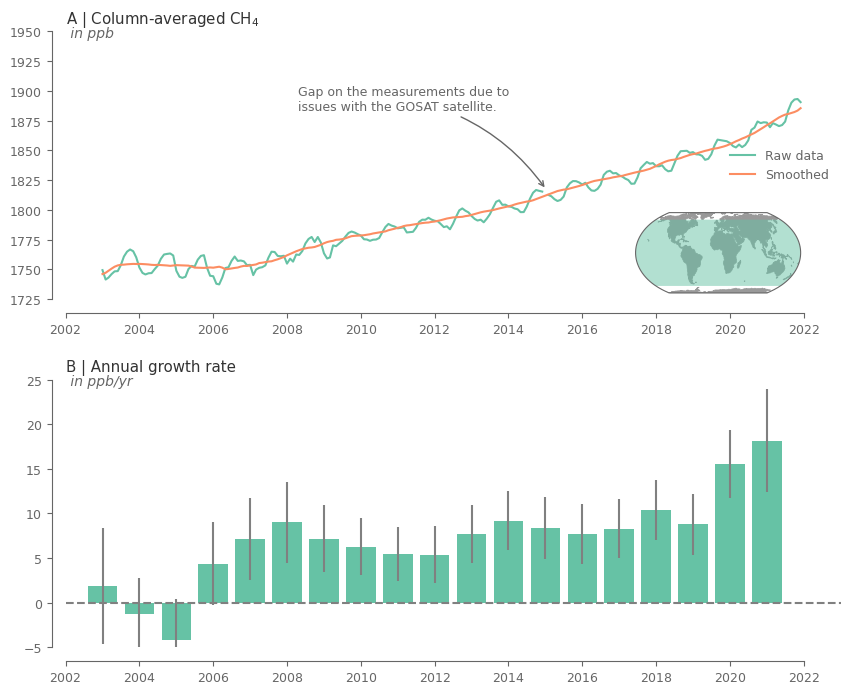

In [28]:
variable = 'xch4'
region = 'Global'

fig, axes = create_summary_plot(
    spatial_aver.sel(ghg=variable, region=region),
    mean_growth_rates.sel(ghg=variable, region=region),
    mean_uncertainty.sel(ghg=variable, region=region),
    aux_var[variable]
)

# add text highlighting the gap on the data
axes[0].annotate(
               'Gap on the measurements due to \nissues with the GOSAT satellite.',
               xy=(pd.to_datetime('20150110'), 1817),
               xytext=(0.3, 0.8),
               textcoords=axes[0].transAxes,
               ha='left', va='top',
               arrowprops=dict(arrowstyle='->', color='.4', connectionstyle='arc3,rad=-0.2')
            )

plt.show()

As you may recall, a critical climate milestone in our fight against climate change was surpassing the 400 ppm mark for CO$_2$ concentrations - an unfortunate occurrence that happened a few years ago. Let's pinpoint when exactly this took place and add this detail to the relevant plot.

In [29]:
# get the date the CO2 concentrations exceed a certain threshold for the first time
thrs = 400e-6  # threshold for CO2 concentration (400 ppm)

is_above_thrs = spatial_aver.sel(ghg='xco2', type='raw', region='Global') >= 400e-6
idx_first_time_step_above_thrs = is_above_thrs.argmax(dim='time', skipna=True)

first_time_thrs = concentration.time.isel(time=idx_first_time_step_above_thrs).values
first_time_thrs = pd.to_datetime(first_time_thrs)
first_time_thrs

Timestamp('2015-03-01 00:00:00')

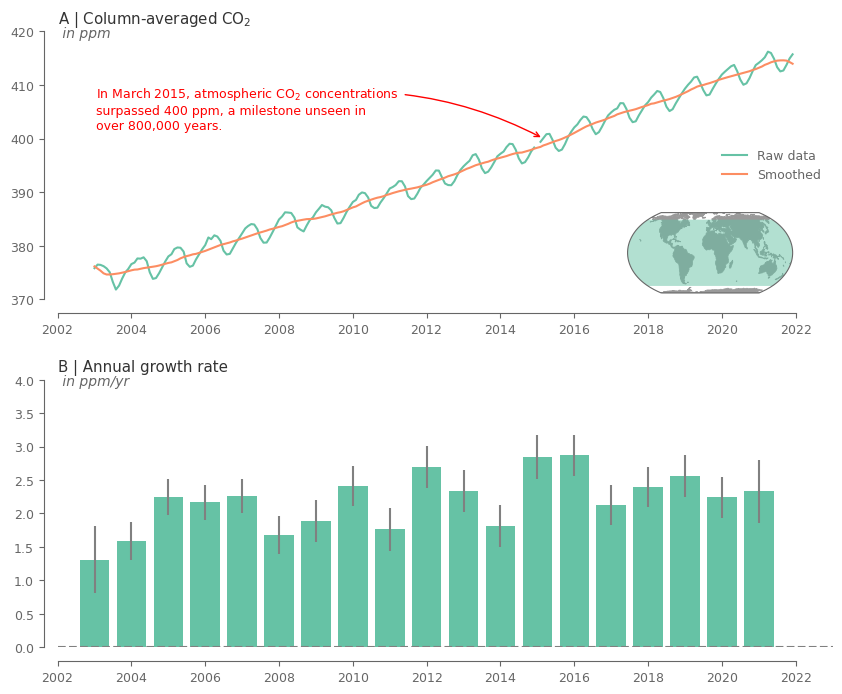

In [30]:
variable = 'xco2'
region = 'Global'

fig, axes = create_summary_plot(
    spatial_aver.sel(ghg=variable, region=region),
    mean_growth_rates.sel(ghg=variable, region=region),
    mean_uncertainty.sel(ghg=variable, region=region),
    aux_var[variable]
)

# add text about the 400ppm in case of CO2 with an arrow pointing to the maximum value
desc = 'In ' + first_time_thrs.strftime('%B %Y') 
desc += ', atmospheric CO$_2$ concentrations \nsurpassed 400 ppm, a milestone unseen in \nover 800,000 years.'
axes[0].annotate(
               desc,
               xy=(first_time_thrs, thrs * 1e6),
               xytext=(0.05, 0.8),
               color='red',
               textcoords=axes[0].transAxes,
               ha='left', va='top',
               arrowprops=dict(arrowstyle='->', color='red', connectionstyle='arc3,rad=-0.2')
            )

plt.show()

From the plots, we can discern a distinct rising trend in GHG concentrations over the entire record, with a noticeable seasonal pattern for both GHGs.

Interestingly, the rate of increase fluctuates considerably from year to year. However, bear in mind that the results for the first and last years are less reliable due to the reduced six-month analysis period.



<div class="alert alert-block alert-info">
    <b>NOTE</b>: <br>
    In the 
<a href="https://www.ipcc.ch/report/ar6/wg3/resources/spm-headline-statements/">6th Assessment Report</a> by the IPCC, there's a critical deadline: To keep our planet's warming under a 2-degree increase, we need global GHG emissions to hit their highest point by 2025. This is the goal we must meet to have a two-thirds chance of successfully limiting our temperature rise.
</div>

#### Comparing CO$_2$ with CH$_4$

So far we have seen that there is indeed an increasing trend for both variables, while both of them have differences in the seasonal cycle and the annual growth rate.

Let's now compare the behaviour across both variables. As the values differ significantly in magnitude, we'll need to normalise the data for a cohesive visual representation.

<div class="alert alert-block alert-warning">
<b>NOTE</b>:<br>
Here we will utilise a simple normalization technique based on global mean and standard deviation. For those interested in delving deeper, there's a concise appendix demonstrating why considering anomalies based on monthly climatology - a method frequently used for other environmental variables - isn't the optimal choice in our scenario.
</div>

In [31]:
spatial_aver_norm = (spatial_aver-spatial_aver.mean('time'))/spatial_aver.std('time')

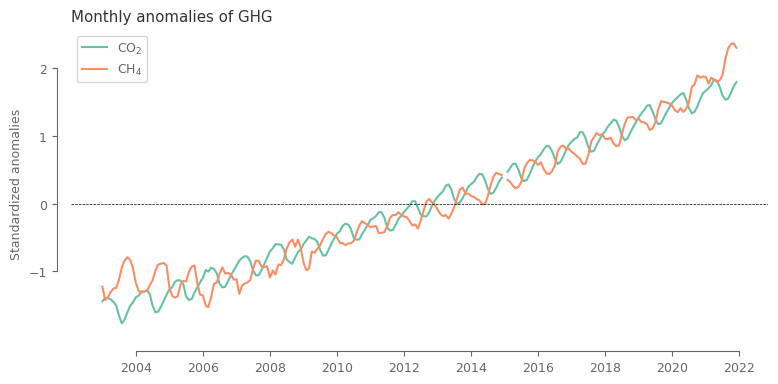

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
spatial_aver_norm.sel(region='Global', type='raw').plot.line(ax=ax, x='time', hue='ghg', add_legend=True, 
                                                             label=[aux_var[i]['shortname'] for i in spatial_aver_norm.ghg.values])
ax.legend()
ax.axhline(0, color='k', ls='--', lw=0.5)
ax.set_ylabel('Standardized anomalies')
ax.set_title('Monthly anomalies of GHG')
sns.despine(ax=ax, trim=True, offset=10) # trimming the y and x axis to be visible only from the fist till the last tick
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # formatting is needed cause the above line breaks the time fo
ax.set_xlabel('')
plt.show()

Upon normalisation, it becomes evident that the key differences between the two variables lie in their respective seasonal cycles, which display a noticeable shift.

### Section 4. Regional Analysis

In the above analysis, we've broadly covered the globe. However, this macro perspective doesn't allow us to examine spatial differences. To do so, let's take a closer look at how the greenhouse gas (GHG) concentrations evolve in the northern and southern hemispheres.

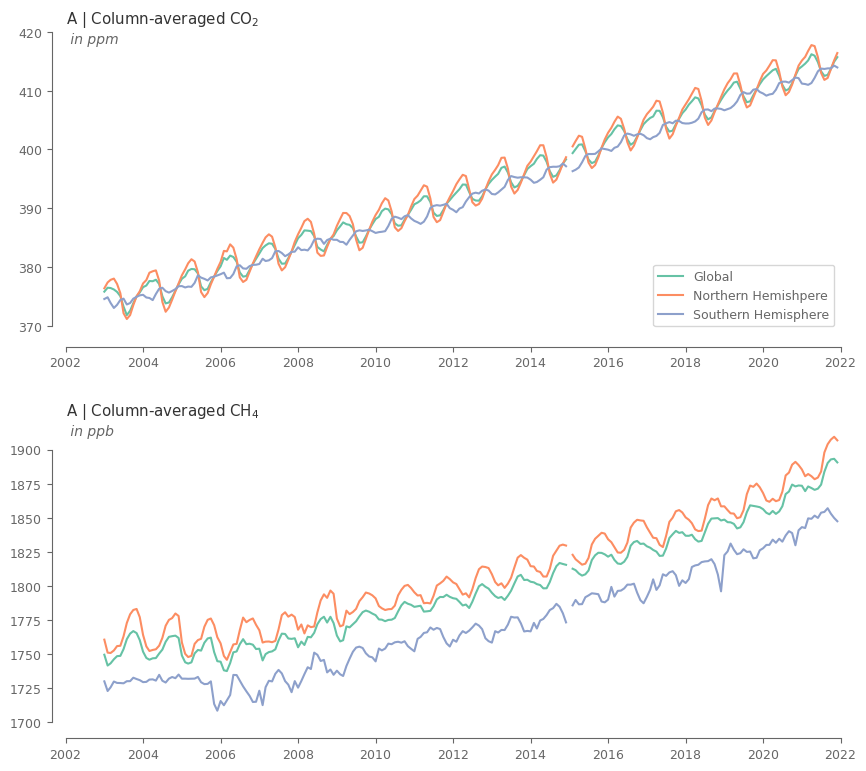

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(10, 9))
(1e6*spatial_aver).sel(ghg='xco2', type='raw').plot.line(ax=axes[0], x='time', hue='region', add_legend=True, label=spatial_aver.region.values)
(1e9*spatial_aver).sel(ghg='xch4', type='raw').plot.line(ax=axes[1], x='time', hue='region', add_legend=False)

axes[0].legend(loc='lower right')
[i_ax.set_xlabel('') for i_ax in axes]

for ax, var in zip(axes, ['xco2', 'xch4']):
    y_label = f'A | Column-averaged {aux_var[var]["shortname"]}'
    ax.set_title(y_label)
    ax.text(0., .96, f' in {aux_var[var]["units"]}', transform=ax.transAxes, fontsize=10, ha='left', style='italic')

    ax.set_xlim(datetime.datetime(2002, 1, 1), datetime.datetime(2022, 1, 1))
    sns.despine(ax=ax, trim=True, offset=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.subplots_adjust(hspace=.3)

We observe a clear differentiation in the methane (CH$_4$) concentrations between the two hemispheres. CO$_2$, on the other hand, demonstrates no seasonality for the southern hemisphere. Could this be due to our focus only on land, and the southern hemisphere simply having less landmass compared to the north?

It is also noteworthy that for both gases, the northern hemisphere has a larger impact in defining the global mean. Possible reasons could be the greater land mass in the northern hemisphere, or perhaps the fact that the majority of the global population and industrial activities are concentrated there.

These differences are evident even in the hemispheric averages. Let's delve deeper by analysing the individual grid cells...

In [36]:
# get the weights for the temporal smoothing based on number of days per month
years = concentration.time.dt.year.values
months = concentration.time.dt.month.values
days_month = [calendar.monthrange(yr, mn)[1] for yr, mn in zip(years, months)]
weights_temporal = concentration.time.astype(int)*0+days_month # temporal weights as xarray object (helps for automatic arrangements later)
# weights should be changed to NaN for the cells that hava NaN in the measurement
weights_temporal = weights_temporal.where(concentration.notnull()).fillna(0)

# created temporally-smoothed timeseries. Note that center=False this time, so the value refers to the 6-month period ending at the date
temp_smoothed = (concentration*weights_temporal).rolling(time=6, min_periods=1, center=False).sum()
temp_smoothed /= weights_temporal.rolling(time=6, min_periods=1, center=False).sum()

Here, we'll define a function for plotting the spatial data for selected variables and four dates, with the first two referring to a year in the early period and the last two to a more recent year.

In [37]:
def spatial_plot(selected_dates, selected_variable='xco2'):

    """
    Inputs:
    selected_dates: a list with 4 dates
    selected_variable: "xco2" (default) or "xch4"
    """

    data_used = temp_smoothed.sel(time=selected_dates, ghg=selected_variable).copy()
    data_used *= aux_var[selected_variable]['unit_factor'] # multiply with unit factor for getting correct units

    # get min/max values for the colorbars for the early and late subsets
    early_dates_data = data_used.sel(time=selected_dates[:2]) # get subset of early dates
    min_early = np.floor(early_dates_data.quantile(.01).values) # find min based on 1st Percentile
    max_early = np.ceil(early_dates_data.quantile(.99).values) # find max based on 99th Percentile
    
    late_dates_data = data_used.sel(time=selected_dates[2:])
    min_late = np.floor(late_dates_data.quantile(.005).values)
    max_late = np.ceil(late_dates_data.quantile(.995).values)
    
    # define the figure
    fig, ax = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(11, 6))
    ax = ax.flatten()

    for i, i_ax in enumerate(ax): # loop through the 4 axes, plot the data, and add background info (Land, Coastline)
        if i<=1:
            values_early = data_used.sel(time=selected_dates[i]) # get the subset to be plotted 
            plot_early = values_early.plot(ax=i_ax, add_colorbar=False, robust=True, vmin=min_early, vmax=max_early, extend='both') # plot
        else:
            values_late = data_used.sel(time=selected_dates[i])
            plot_late = values_late.plot(ax=i_ax, add_colorbar=False, robust=True, vmin=min_late, vmax=max_late, extend='both')

        i_ax.add_feature(cfeature.LAND) # add land
        i_ax.add_feature(cfeature.COASTLINE) # add coastline
        # add title
        start_month = (pd.to_datetime(selected_dates[i])-pd.DateOffset(months=5)).strftime("%B") # get start month
        end_month = pd.to_datetime(selected_dates[i])
        i_ax.set_title(end_month.strftime(f'{start_month} - %B %Y')) # add the final title

    # colorbar of early dates
    fig.subplots_adjust(right=1) # define where the new axes fo
    cbar_ax_early = fig.add_axes([1, 0.53, 0.015, 0.34]) # define where the new axis for the colorbar will be added and specify its dimensions
    fig.colorbar(plot_early, cax=cbar_ax_early, extend='both') # add the colorbar
    cbar_ax_early.set_title(f"{aux_var[selected_variable]['shortname']}\n[{aux_var[selected_variable]['units']}]", size=10) # add title

    # colorbar of late dates
    fig.subplots_adjust(right=1)
    cbar_ax_late = fig.add_axes([1, 0.03, 0.015, 0.34])
    fig.colorbar(plot_late, cax=cbar_ax_late, extend='both')
    cbar_ax_late.set_title(f"{aux_var[selected_variable]['shortname']}\n[{aux_var[selected_variable]['units']}]", size=10)

    fig.tight_layout()
    plt.show()

/tmp/ipykernel_1145/988431502.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


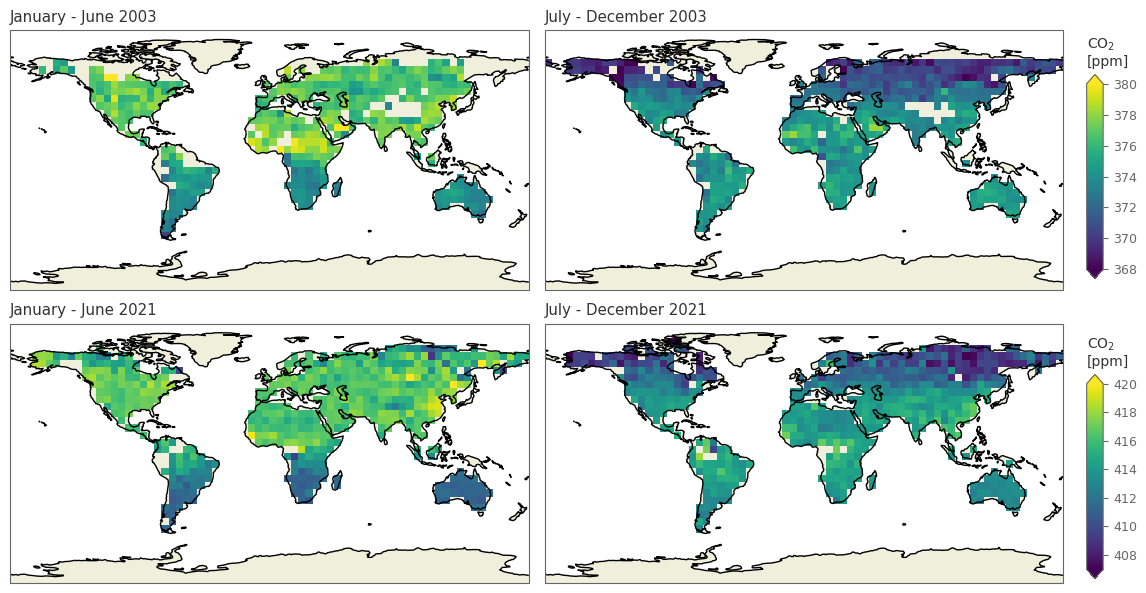

In [38]:
spatial_plot(['20030601', '20031201', '20210601', '20211201'], 'xco2')

/tmp/ipykernel_1145/988431502.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


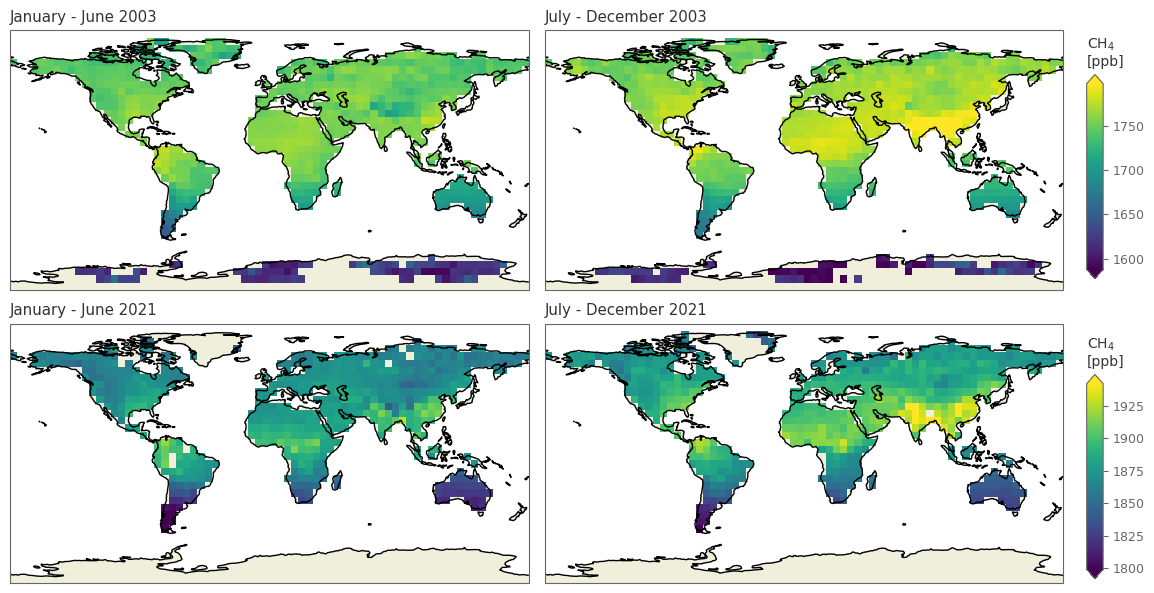

In [39]:
spatial_plot(['20030601', '20031201', '20210601', '20211201'], 'xch4')

### Section 5: Summary

<div class="alert alert-block alert-success">

In this tutorial, we analysed the concentrations of two key GHGs, namely carbon dioxide (CO$_2$), and methane (CH$_4$). We used data from satellite measurements taken between 2003 and 2021.<br>
The data showed a consistently increasing trend for both GHGs — a very concerning feature, which, as much research has shown, is the main cause of ongoing climate change. Both CO$_2$ and CH$_4$ show a seasonal cycle, slightly offset, with substantial differences in concentrations between the hemispheres, particularly for CH$_4$.<br>
Having gained a deeper understanding of GHG, let's continue our exploration with our [next tutorial](https://github.com/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/02_temperature.ipynb) and see what's happening to Earth's temperature.
</div>

### Section 6. Useful Links
For those interested in delving deeper into GHGs, here are some links to relevant articles and visualisations:
1. [Greenhouse gas concentrations Climate Indicators Report](https://climate.copernicus.eu/climate-indicators/greenhouse-gas-concentrations)
2. [Global Monitorin Laboratory](https://gml.noaa.gov/ccgg/) from [NOAA](https://www.noaa.gov/), with a lot of information, relevant plots, and raw data that can be freely donwloaded. 
3. Lashof, D., Ahuja, D. Relative contributions of greenhouse gas emissions to global warming. Nature 344, 529–531 (1990). https://doi.org/10.1038/344529a0
4. Buchwitz, M., Reuter, M., Schneising, O., Noël, S., Gier, B., Bovensmann, H., Burrows, J. P., Boesch, H., Anand, J., Parker, R. J., Somkuti, P., Detmers, R. G., Hasekamp, O. P., Aben, I., Butz, A., Kuze, A., Suto, H., Yoshida, Y., Crisp, D., and O'Dell, C.: Computation and analysis of atmospheric carbon dioxide annual mean growth rates from satellite observations during 2003–2016, Atmos. Chem. Phys., 18, 17355–17370 (2018), https://doi.org/10.5194/acp-18-17355-2018
5. Buchwitz, M., Dils, B., Boesch, H., Brunner, D., Butz, A., Crevoisier, C., Detmers, R., Frankenberg, C., Hasekamp, O., Hewson, W., Laeng, A., Noël, S., Notholt, J., Parker, R., Reuter, M., Schneising, O., Somkuti, P., Sundström, A.-M., and De Wachter, E.: ESA Climate Change Initiative (CCI) Product Validation and Intercomparison Report (PVIR) for the Essential Climate Variable (ECV) Greenhouse Gases (GHG) for data set Climate Research Data Package No. 4 (CRDP#4), Technical Report, version 5, available at: http://www.esa-ghg-cci.org/?q=webfm_send/352, 253 pp. (2017)

### Appendices
Earlier, we mentioned that we only used the global mean and standard deviation to compare the variables, instead of using monthly climatology. In the appendices, we'll explain how the monthly climatology looks like and why using it isn't the best approach in this case.

#### Appendix A: Monthly climatology of the variables

In [40]:
# what is normally done assuming a 'stationary' behaviour of the variable
climatology_mean = concentration.groupby('time.month').mean('time') # climatological monthly mean (no weighting used, as it will only affect Februaries for leap years)
climatology_std = concentration.groupby('time.month').std('time') # climatological standard deviation for each month
anomalies = (concentration.groupby('time.month') - climatology_mean) # anomalies after removing mean
anomalies = anomalies.groupby('time.month')/climatology_std # final anomalies after dividing with standard deviation
anomalies = area_weighted_spatial_average(anomalies.sel(lat=slice(-60, 60))) # get global average

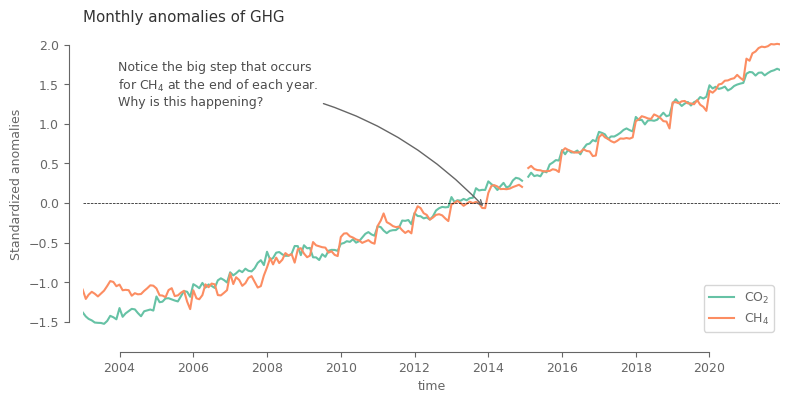

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
anomalies.plot.line(x='time', ax=ax, label=[aux_var[i]['shortname'] for i in spatial_aver_norm.ghg.values])
ax.legend()
ax.axhline(0, color='k', ls='--', lw=0.5)
ax.set_xlim(anomalies.time.values[0], anomalies.time.values[-1])
sns.move_legend(ax, loc='lower right')
sns.despine(ax=ax, trim=True, offset=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_title('Monthly anomalies of GHG')
ax.set_ylabel('Standardized anomalies')

date_annotate = pd.to_datetime('201312', format='%Y%m')
ax.annotate(
            'Notice the big step that occurs \nfor CH$_4$ at the end of each year.\nWhy is this happening?',
            xy=(date_annotate, anomalies.sel(ghg='xch4', time=date_annotate).values),
            xytext=(0.05, 0.9),
            textcoords=ax.transAxes,
            ha='left', va='top', color='.3',
            arrowprops=dict(arrowstyle='->', color='.4', connectionstyle='arc3,rad=-0.2')
           )

plt.show()

Let's plot the monthly climatology (global average) to understand if the issue is related to that step.

In [42]:
clim_spatial = climatology_mean.sel(lat=slice(-60, 60)).weighted(np.cos(np.deg2rad(climatology_mean.lat)).clip(0, 1)).mean(['lat', 'lon'])

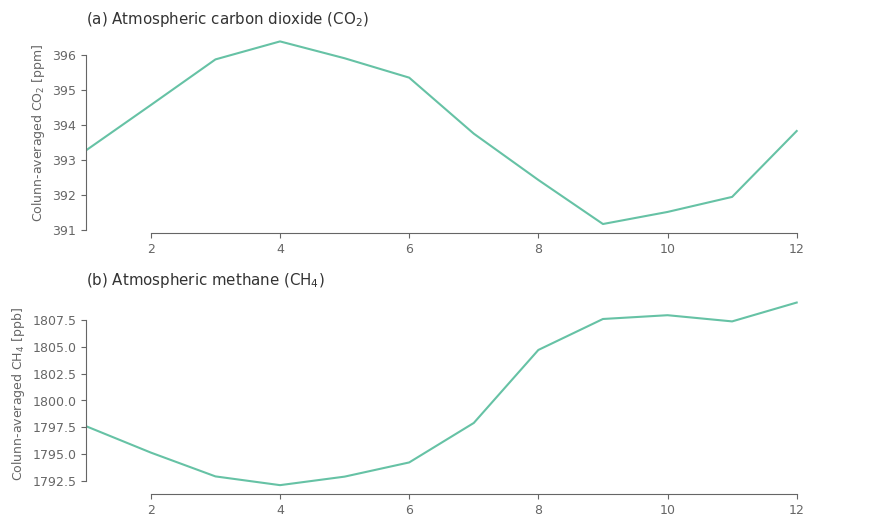

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

for i, j in enumerate(clim_spatial.ghg.values):

    ax[i].plot(clim_spatial.month.values, clim_spatial.sel(ghg=j).values*aux_var[j]['unit_factor']) 
    
    ax[i].set_xlim(1, 13)

    ax[i].set_title(f'({ABC[i]}) '+ aux_var[j]['name'] + ' (' + aux_var[j]['shortname'] + ')')
    ax[i].set_ylabel('Colunn-averaged '+ aux_var[j]['shortname']  + ' [' + aux_var[j]['units'] + ']')

    sns.despine(ax=ax[i], trim=True) # trimming the y and x axis to be visible only from the fist till the last tick

fig.subplots_adjust(hspace=.3)

Perhaps it's more informative to present the results in polar coordinates, since, from a climatological point of view, the months follow a circular behaviour with December being similar to January.

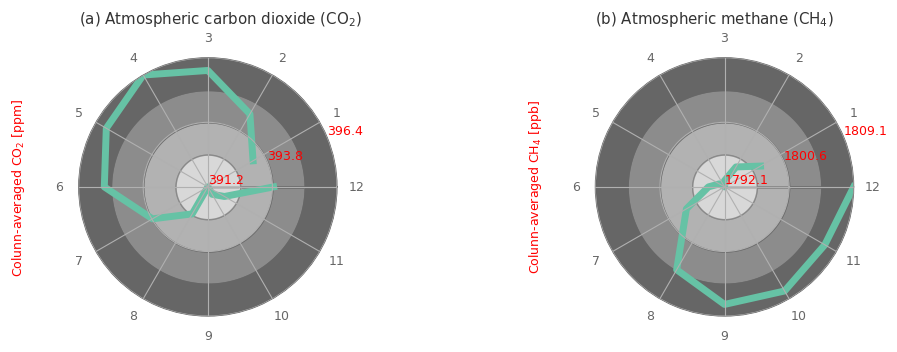

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={'projection': 'polar'})

for i, j in enumerate(clim_spatial.ghg.values):

    yy_values = clim_spatial.sel(ghg=j).values*aux_var[j]['unit_factor'] # get the values and multiply with the unit factor
    ax[i].plot( (clim_spatial.month.values)/12*2*np.pi, yy_values, linewidth=5 ) # plot the line
    
    # color the graph based on y value for easily differentiating between the magnitudes for the months
    segments = np.linspace(np.array(yy_values).min()*1, np.array(yy_values).max()*1., 5)
    for seg_min, seg_max, i_alpha in zip(segments[:-1], segments[1:], np.arange(0.25, 1.01, .25)):
        ax[i].fill_between(x=np.linspace(0, 2*np.pi, 360), y1=seg_max, y2=seg_min, color='.4', alpha=i_alpha)

    ax[i].set_ylim(np.array(yy_values).min()*1, np.array(yy_values).max()*1.)
    
    ax[i].set_xticks((clim_spatial.month.values)/12*2*np.pi)
    ax[i].set_xticklabels(range(1, 13))
    ax[i].set_yticks(segments[::2], labels=np.round(segments, 1)[::2])
    ax[i].set_axisbelow(False) # otherwise the green line hiddes the yticks (red values) 
    ax[i].tick_params(axis='y', colors='red', size=14, zorder=10)
    ax[i].set_title(f'({ABC[i]}) '+ aux_var[j]['name'] + ' (' + aux_var[j]['shortname'] + ')')
    ax[i].yaxis.set_label_coords(-0.2, 1)
    ax[i].set_ylabel('Colunn-averaged '+ aux_var[j]['shortname']  + ' [' + aux_var[j]['units'] + ']', color='red')

fig.subplots_adjust(wspace=1)

The significant difference in values between the mean state of January and December for both GHGs, particularly CH$_4$, indicates that, on average, there's already a substantial increase in concentrations just over a single year. This disrupts the expected seasonal cycle, as we would normally expect January and December values to be very close.

As a result of this substantial reduction in the mean state of January compared to December, we observe a substantial jump for every January, as the climatological mean is small, thus the anomalies become large.

To robustly compute the anomalies, we should not only remove the seasonal cycle but also detrend the data, as **this dataset is highly non-stationary**!

#### Appendix B: Using reanalysis data available from the Atmopshere Data Store (ADS)

In addition to satellite measurements for the GHGs, there are also global reanalysis products providing information about CO$_2$ and CH$_4$. Let's utilise the one available in the Atmosphere Data Store (ADS).

As we did with the CDS API, the same is required for the ADS, with a new registration to be completed at https://ads.atmosphere.copernicus.eu/api-how-to.

In [45]:
# ADS key
ads_url = 'https://ads.atmosphere.copernicus.eu/api/v2'
ads_key = 'YOUR KEY' # please add your key here the format should be as {uid}:{api-key}

Get GHG data from reanalysis [(EGG4) from ADS](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-ghg-reanalysis-egg4-monthly?tab=overview). We use the monthly mean data for speeding the process. For those interested, there's also a [daily dataset](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-ghg-reanalysis-egg4?tab=overview) available. 

In [46]:
# get monthly mean grennhouse gases data from Atmosphere Data Store (it takes around 2 minutes)
c = cdsapi.Client(url=ads_url, key=ads_key)

c.retrieve(
    'cams-global-ghg-reanalysis-egg4-monthly',
    {
     'product_type': 'monthly_mean',
     'variable': ['ch4_column_mean_molar_fraction', 'co2_column_mean_molar_fraction'], # get the available variables
     'year': list(range(2003, 2021)), # get all available years (2003, 2004, ..., 2020)
     'month': list(range(1, 13)), # get all months Jan (1) up to Dec (12)
     'format': 'netcdf',
    },
    f'{dir_loc}greenhouse_gases.nc')

2023-07-02 11:30:13,156 INFO Welcome to the CDS
2023-07-02 11:30:13,158 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-ghg-reanalysis-egg4-monthly
2023-07-02 11:30:13,284 INFO Request is completed
2023-07-02 11:30:13,285 INFO Downloading https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data1/adaptor.mars.external-1683983665.986999-18127-5-994cf598-7b63-4f76-915e-6310a89f2575.nc to data/greenhouse_gases.nc (95.3M)
2023-07-02 11:31:32,102 INFO Download rate 1.2M/s   


Result(content_length=99952612,content_type=application/x-netcdf,location=https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data1/adaptor.mars.external-1683983665.986999-18127-5-994cf598-7b63-4f76-915e-6310a89f2575.nc)

In [47]:
# open the GHG data and inspect the Dataset
# when the data are opened as below using "with" then the link to the actual dataset is closed, meaning that any other program can also access the file in the directory
# this is not the case for the normal opening of the file, as for the co2_satellites in the main section of this tutorial.
with xr.open_dataset(f'{dir_loc}greenhouse_gases.nc') as ghg_reanalysis:
    pass
ghg_reanalysis

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 241, time: 216)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2020-12-01
Data variables:
    tcch4      (time, latitude, longitude) float32 ...
    tcco2      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-13 13:14:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

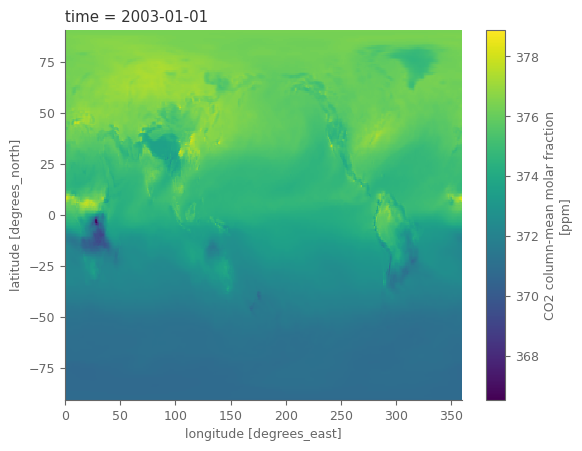

In [48]:
# "quick and dirty" plot of the data
ghg_reanalysis['tcco2'].isel(time=0).plot()

As we can observe, the dataset is a three-dimensional cube (latitude, longitude, time) with information for two variables (CO$_2$, CH$_4$). Furthermore, the spatial grid is 0.75 degrees and the data also includes oceans. Therefore, this dataset varies somewhat from the satellite data, making the task slightly more challenging, but it's always enriching to examine results from more than one dataset... :)


Lastly, we require the land-sea mask from ERA5 data. This is necessary because the GHG measurements from the satellites aren't available over the oceans. So we want to use a mask when using GHG data from the reanalysis dataset available from ADS. Note that the resolution (grid) should be specified, because the default one when downloading the data (0.25) differs from the resolution of GHG (0.75).

In [49]:
c = cdsapi.Client(url=cds_url, key=cds_key)

# we just need one random slice of land-sea mask (data are same for all time steps)
c.retrieve(
    'reanalysis-era5-single-levels',
    {
     'product_type': 'reanalysis',
     'variable': 'land_sea_mask',
     'year': '2009',
     'month': '10',
     'day': '16',
     'time': '00:00',
     'grid': [0.75, 0.75], # grid is specified because the default resolution is different
     'format': 'netcdf',
    },
    f'{dir_loc}land_sea_mask.nc')

2023-07-02 11:31:33,424 INFO Welcome to the CDS
2023-07-02 11:31:33,425 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-07-02 11:31:33,693 INFO Request is queued
2023-07-02 11:31:34,798 INFO Request is running
2023-07-02 11:31:36,416 INFO Request is completed
2023-07-02 11:31:36,417 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data4/adaptor.mars.internal-1688293894.9983578-6162-16-2fe4ec0e-414d-4e25-af36-212b48c9c900.nc to data/land_sea_mask.nc (229.8K)
2023-07-02 11:31:37,423 INFO Download rate 228.6K/s


Result(content_length=235364,content_type=application/x-netcdf,location=https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data4/adaptor.mars.internal-1688293894.9983578-6162-16-2fe4ec0e-414d-4e25-af36-212b48c9c900.nc)

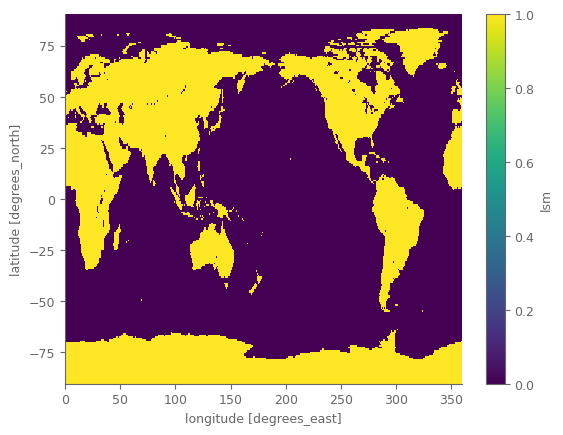

In [52]:
# read the land-sea mask and visualize ("quick and dirty") the data
data_mask = xr.open_dataarray(f'{dir_loc}land_sea_mask.nc').isel(time=0, drop=True)
is_land = data_mask >= 0.5 # make data boolean (1-land, 0-sea), by converting all cells with at least 50% land, as only land
is_land.plot()

To start with, let's apply the land mask on the reanalysis data so that they are comparable with the satellite data. Also, let's name the coordinates and keys with the same names as with the satellite data and also order the latitudes in the same way (ascending).

In [56]:
ghg_reanalysis_land = ghg_reanalysis.where(is_land) # keep only land data
ghg_reanalysis_land = ghg_reanalysis_land.sortby('latitude') # sort ascending
ghg_reanalysis_land = ghg_reanalysis_land.rename({'latitude': 'lat', 'longitude': 'lon'}) # rename same as satellite coordinates
ghg_reanalysis_land = ghg_reanalysis_land.rename({'tcch4': 'xch4', 'tcco2': 'xco2'}) # rename same as satellite names
ghg_reanalysis_land = ghg_reanalysis_land.to_array('ghg')
ghg_reanalysis_land = area_weighted_spatial_average(ghg_reanalysis_land)

ghg_satellites_land = area_weighted_spatial_average(concentration)
unit_factor_xr = xr.DataArray([aux_var[i_ghg]['unit_factor'] for i_ghg in aux_var], dims={'ghg': aux_var.keys()}) # auxiliary variable
ghg_satellites_land *= unit_factor_xr # multiply with the unit factor for having the correct units

Lastly, we'll create the final array by combining the data from both products and deriving the global average.

In [57]:
ghg_both_datasets = xr.concat([ghg_satellites_land, ghg_reanalysis_land], dim=pd.Index(['satellites', 'reanalysis'], name='product'))
ghg_both_datasets.to_dataset('ghg')

<xarray.Dataset>
Dimensions:  (product: 2, time: 228)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2021-12-01
  * product  (product) object 'satellites' 'reanalysis'
Data variables:
    xch4     (product, time) float64 1.741e+03 1.739e+03 1.743e+03 ... nan nan
    xco2     (product, time) float64 375.8 376.5 376.4 376.2 ... nan nan nan nan

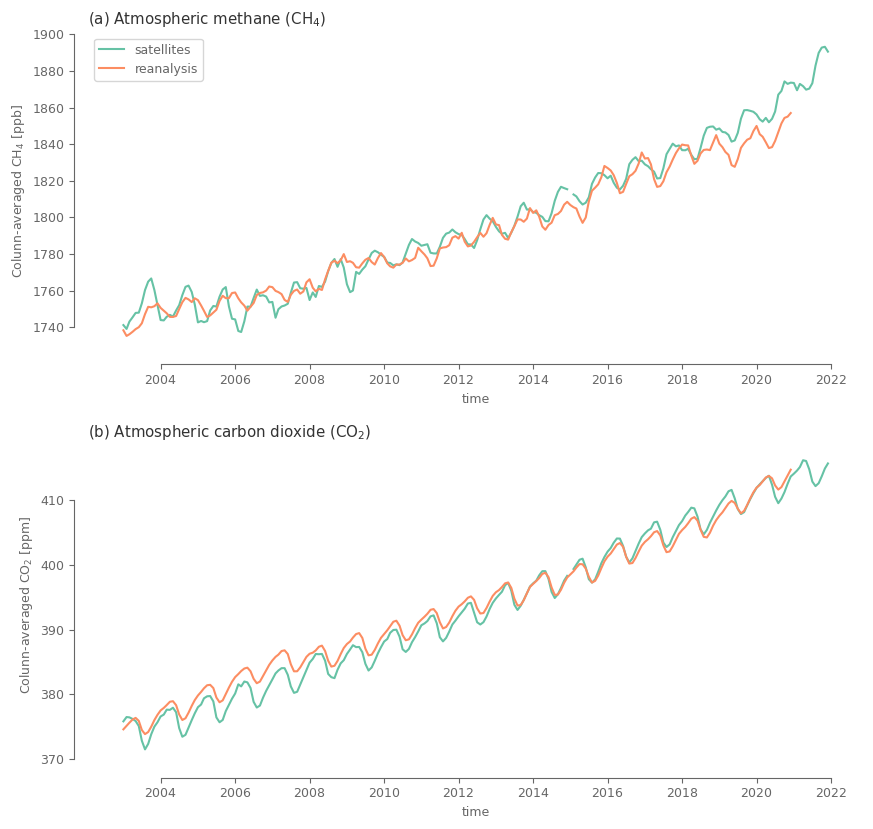

In [58]:
fig, axes = plt.subplots(2, 1, figsize=(10, 9.5))
axes = axes.flatten()
for i_abc, i_ax, i_dom in zip(ABC, axes, ghg_both_datasets.ghg):
    subtitle = f'({i_abc}) {aux_var[i_dom.values.tolist()]["name"]} ({aux_var[i_dom.values.tolist()]["shortname"]})'
    y_label = f'Colunn-averaged {aux_var[i_dom.values.tolist()]["shortname"]} [{aux_var[i_dom.values.tolist()]["units"]}]'
    ghg_both_datasets.sel(ghg=i_dom).plot.line(hue='product', ax=i_ax, label=ghg_both_datasets.product.values)

    i_ax.set_title(subtitle)
    i_ax.set_ylabel(y_label)
    sns.despine(ax=i_ax, trim=True, offset=10)
    i_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

axes[0].legend()
axes[1].get_legend().remove()

fig.subplots_adjust(hspace=.3)

plt.show()

Both satellites and reanalysis data indicate the strong increasing trend for both GHG, with the trend being of similar magnitude.

At the same time we can observe some differences:

For the CO$_2$ data the differences between the two sources are mainly in the magnitude of the concentrations for around the first half of the data (2003-2013). For the CH$_4$, however, the differences are more substantial, and for most of the analysed period. These differences can be related to the methodology for generating the products, and the fact that satellite data are not complete in space and time, so there could be important information omitted.